<a href="https://colab.research.google.com/github/finedominos/synthetised-speech-dataset/blob/master/Dataset_Evaluation_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset evaluation pipeline
####*evaluation of synthetic audio files*

INPUTS:


1.   *json_dataset_path* points towards a json file that must contains the set of textual sentences of the dataset in the format generated by the notebook "Dataset Creation", following this syntax:


```
[
    [
        "librispeech-code-of-the-sentence",
        "UPPERCASE SENTENCE"
    ],
    [
        "librispeech-code-of-the-sentence",
        "UPPERCASE SENTENCE"
    ],
    ...
]
```

2.   *audio_dataset_path* points to a zip file containing the synthesized audio sentences, each of them stored in the folder named after the TTS method used to generate it, following an architecture such as "*zip_folder_name/method_name/librispeech_code.wav*" (example: "*audio_sentences/Gtts/3752-4944-0006.wav*")

both json_dataset and audio_dataset must contain the same sentences

If you're not using the 4 methods for which this project is implemented, you'll need to addapt the Audio dataset import section, as well as all the execution part of the differents metrics... (Work in progress)



In [ ]:
json_dataset_path = "/content/subset_345_sentences.json"
audio_dataset_path = "audio_345_sentences/"

libraries imports:

In [ ]:
import numpy as np
from pathlib import Path
import random
import shutil
import IPython
import os
import IPython.display as ipd
import matplotlib.pyplot as plt
import json
import seaborn as sns
import pandas as pd
import tqdm.notebook as tq
from math import sqrt 

## Sentences dataset import

In [ ]:
with open(json_dataset_path, "r") as jsonfile:
   dataset_json = json.load(jsonfile)
dataset_json = np.asarray(dataset_json)

print("\nExample: 1st sentence of the dataset:\n", dataset_json[0])


Example: 1st element of dataset_100:
 ['3752-4944-0006' 'HAVE YOU MANY VISITORS CAPTAIN BURGESS VERY FEW']


## Audio Dataset import

In [ ]:
!unzip audio_sentences_345.zip

In [ ]:
list_nvidia_audio_paths = [str(file) for file in Path().glob(audio_dataset_path+"Nvidia/*.wav")]
list_gtts_audio_paths = [str(file) for file in Path().glob(audio_dataset_path+"Gtts/*.wav")]
list_ibm_audio_paths = [str(file) for file in Path().glob(audio_dataset_path+"IBM/*.wav")]
list_Microsoft_audio_paths = [str(file) for file in Path().glob(audio_dataset_path+"Microsoft/*.wav")]

assert(len(dataset_json)==len(list_nvidia_audio_paths)==len(list_gtts_audio_paths)==len(list_ibm_audio_paths)==len(list_Microsoft_audio_paths))
print("length of the dataset:", len(dataset_json))

length of the dataset: 345


In [ ]:
# Post-processing the wavefiles because our speech recogniser doesn't like floats arrays for audio...
from scipy.io import wavfile
import itertools

for path in itertools.chain(list_nvidia_audio_paths, list_gtts_audio_paths, list_ibm_audio_paths, list_Microsoft_audio_paths):
  fs, data = wavfile.read(path)
  # Convert `data` to 32 bit integers:
  y = (np.iinfo(np.int32).max * (data/np.abs(data).max())).astype(np.int32)

  wavfile.write(path, fs, y)

## STT Libraries

In [ ]:
!sudo apt-get install -qq python python-dev python-pip build-essential swig libpulse-dev

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 26.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package libpulse-mainloop-glib0:amd64.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../00-libpulse-mainloop-glib0_1%3a11.1-1ubuntu7.11_amd64.deb ...
Unpacking libpulse-mainloop-glib0:amd64 (1:11.1-1ubuntu7.11) ...
Selecting previously unselected package libpulse-dev:amd64.
Preparing to unpack .../01-libpulse-dev_1%3a11.1-1ubuntu7.11_amd64.deb ...
Unpacking libpulse-dev:amd64 (1:11.1-1ubuntu7.11) ...
Selecting previously unselected package libpython-all-dev:amd64.
P

In [ ]:
!pip install SpeechRecognition pydub
# !pip install pocketsphinx
!pip install jiwer

     |████████████████████████████████| 32.8MB 73kB/s 
     |████████████████████████████████| 51kB 2.4MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149797 sha256=da95913f19fcbfe70b2bc0fff3fefe8c0b8e6b312e59280907b8f4b17237ac19
  Stored in directory: /root/.cache/pip/wheels/b3/26/73/4b48503bac73f01cf18e52cd250947049a7f339e940c5df8fc
Successfully built python-Levenshtein


In [ ]:
import speech_recognition as sr
# import pocketsphinx
import jiwer #library for wer
import json

## WER metric
####*Word Error Rate computed between the original sentences and the ones re-transcribed to text from the synthesized files with use of the STT library imported above*

In [ ]:
# nb: WER = Word Error Rate
def dataset_WER(list_of_audio_path, original_sentences):
  wer_list=[]
  for i, audio_path in tq.tqdm(enumerate(list_of_audio_path), total=len(list_of_audio_path)):
    sentence_id = (audio_path.split('/')[-1]).split(".")[0]
    # Finding the original sentence
    original_found = False
    for j, sentence in enumerate(original_sentences):
      if sentence_id == original_sentences[j,0]:
        text_original = original_sentences[j,1]
        original_found = True
    if not original_found:
      raise Exception("original sentence not found")
    
    # Reading the audio file
    recogniser = sr.Recognizer()
    with sr.AudioFile(audio_path) as source:
      # listen for the data (load audio to memory)
      audio_data = recogniser.record(source)
    
    # STT or the audio file and WER
    try:
      # GOOGLE speech to text
      text_google = recogniser.recognize_google(audio_data).upper()
      # Compute Word Error Rate
      wer_google = jiwer.wer(text_original, text_google)
    except:
      print("error with sentence: ",sentence_id,"(actual sentence:",text_original,")")
      wer_google = 1
    wer_list.append([wer_google, text_original, text_google])

  return np.asarray(wer_list)

In [ ]:
def print_wer_stats(wer_list):
  number_of_perfect_match = 0
  wer_mean = 0
  for wer in wer_list:
    wer_mean += float(wer[0])
    if float(wer[0])==0:
      number_of_perfect_match += 1
  print("number of perfect matches: {}/{}".format(number_of_perfect_match, len(wer_list)))
  print("wer mean:",wer_mean/len(wer_list))

In [ ]:
nvidia_WER = dataset_WER(list_nvidia_audio_paths, dataset_json)
microsoft_WER = dataset_WER(list_Microsoft_audio_paths, dataset_json)
gtts_WER = dataset_WER(list_gtts_audio_paths, dataset_json)
ibm_WER = dataset_WER(list_ibm_audio_paths, dataset_json)

In [ ]:
print("GTTS:")
print_wer_stats(gtts_WER)
print("\n\nNVIDIA")
print_wer_stats(nvidia_WER)
print("\n\nMICROSOFT")
print_wer_stats(microsoft_WER)
print("\n\nIBM")
print_wer_stats(ibm_WER)

GTTS:
number of perfect matches: 125/345
wer mean: 0.1476592754722384


NVIDIA
number of perfect matches: 186/345
wer mean: 0.07612237942531386


MICROSOFT
number of perfect matches: 252/345
wer mean: 0.03986361546800366


IBM
number of perfect matches: 203/345
wer mean: 0.07435763071077375


In [ ]:
# Saving results: 

from google.colab import drive
drive.mount('/content/gdrive')

with open("/content/gdrive/My Drive/gtts_WER.json", "w") as jsonfile:
   json.dump(gtts_WER.tolist(), jsonfile, indent=4)
with open("/content/gdrive/My Drive/nvidia_WER.json", "w") as jsonfile:
   json.dump(nvidia_WER.tolist(), jsonfile, indent=4)
with open("/content/gdrive/My Drive/microsoft_WER.json", "w") as jsonfile:
   json.dump(microsoft_WER.tolist(), jsonfile, indent=4)
with open("/content/gdrive/My Drive/ibm_WER.json", "w") as jsonfile:
   json.dump(ibm_WER.tolist(), jsonfile, indent=4)

Mounted at /content/gdrive


## Speech metrics
####*MOSnet and SRMR*

This part works with the audio files from the dataset and a library called speechmetrics

In [ ]:
!pip install git+https://github.com/aliutkus/speechmetrics#egg=speechmetrics[cpu]

In [ ]:
import speechmetrics
window_length = 5 # seconds
metrics = speechmetrics.load('absolute', window_length)

absolute_metric_nvidia = []
for _, audio_path in tq.tqdm(enumerate(list_nvidia_audio_paths), total=len(list_nvidia_audio_paths)):
  sentence_id = (audio_path.split('/')[-1]).split(".")[0]
  scores = metrics(audio_path)
  absolute_metric_nvidia.append([sentence_id, scores])

absolute_metric_gtts = []
for _, audio_path in tq.tqdm(enumerate(list_gtts_audio_paths), total=len(list_gtts_audio_paths)):
  sentence_id = (audio_path.split('/')[-1]).split(".")[0]
  scores = metrics(audio_path)
  absolute_metric_gtts.append([sentence_id, scores])

absolute_metric_ibm = []
for _, audio_path in tq.tqdm(enumerate(list_ibm_audio_paths), total=len(list_ibm_audio_paths)):
  sentence_id = (audio_path.split('/')[-1]).split(".")[0]
  scores = metrics(audio_path)
  absolute_metric_ibm.append([sentence_id, scores])

absolute_metric_microsoft = []
for _, audio_path in tq.tqdm(enumerate(list_Microsoft_audio_paths), total=len(list_Microsoft_audio_paths)):
  sentence_id = (audio_path.split('/')[-1]).split(".")[0]
  scores = metrics(audio_path)
  absolute_metric_microsoft.append([sentence_id, scores])


Loaded  speechmetrics.absolute.mosnet
Loaded  speechmetrics.absolute.srmr


In [ ]:
def compute_means_absolute_metrics(metrics_array):
  mean_mosnet = 0
  mean_srmr = 0
  std_mosnet = 0
  std_srmr = 0
  for element in metrics_array:
    try:
      mean_mosnet += element[1]['mosnet']
      mean_srmr += element[1]['srmr']
      std_mosnet = element[1]['mosnet']**2
      std_srmr = element[1]['srmr']**2
    except:
      mean_mosnet += element[1]['mosnet'][0]
      mean_srmr += element[1]['srmr'][0]
      std_mosnet = element[1]['mosnet'][0]**2
      std_srmr = element[1]['srmr'][0]**2
      print("WARNING: element", element[0], "has more than one value for mosnet/srmr metrics")
  mean_mosnet /= len(metrics_array)
  mean_srmr /= len(metrics_array)
  std_mosnet = sqrt(std_mosnet)
  std_srmr = sqrt(std_srmr)
  std_mosnet /= len(metrics_array)
  std_srmr /= len(metrics_array)
  return mean_mosnet, mean_srmr, std_mosnet, std_srmr

In [ ]:
nvidia_mean_mosnet, nvidia_mean_srmr, nvidia_std_mosnet, nvidia_std_srmr = compute_means_absolute_metrics(absolute_metric_nvidia)
print("NVIDIA's results:     MOSNET: mean:{:.3f}, std:{:.3f};   SRMR: mean:{:.3f}, std:{:.3f}\n"
      .format(nvidia_mean_mosnet[0], nvidia_std_mosnet, nvidia_mean_srmr[0], nvidia_std_srmr))

microsoft_mean_mosnet, microsoft_mean_srmr, microsoft_std_mosnet, microsoft_std_srmr = compute_means_absolute_metrics(absolute_metric_microsoft)
print("Microsoft's results:  MOSNET: mean:{:.3f}, std:{:.3f};   SRMR: mean:{:.3f}, std:{:.3f}\n"
      .format(microsoft_mean_mosnet[0], microsoft_std_mosnet, microsoft_mean_srmr[0], microsoft_std_srmr))

ibm_mean_mosnet, ibm_mean_srmr, ibm_std_mosnet, ibm_std_srmr = compute_means_absolute_metrics(absolute_metric_ibm)
print("IBM's results:        MOSNET: mean:{:.3f}, std:{:.3f};   SRMR: mean:{:.3f}, std:{:.3f}\n"
      .format(ibm_mean_mosnet[0], ibm_std_mosnet, ibm_mean_srmr[0], ibm_std_srmr))

gtts_mean_mosnet, gtts_mean_srmr, gtts_std_mosnet, gtts_std_srmr = compute_means_absolute_metrics(absolute_metric_gtts)
print("GTTS's results:       MOSNET: mean:{:.3f}, std:{:.3f};   SRMR: mean:{:.3f}, std:{:.3f}\n"
      .format(gtts_mean_mosnet[0], gtts_std_mosnet, gtts_mean_srmr[0], gtts_std_srmr))


NVIDIA's results:     MOSNET: mean:2.953, std:0.010;   SRMR: mean:12.631, std:0.033

Microsoft's results:  MOSNET: mean:3.584, std:0.011;   SRMR: mean:17.954, std:0.048

IBM's results:        MOSNET: mean:3.066, std:0.009;   SRMR: mean:15.282, std:0.047

GTTS's results:       MOSNET: mean:3.316, std:0.010;   SRMR: mean:17.614, std:0.055



In [ ]:
# Saving results: 

dict_metrics = {}

dict_metrics['Nvidia'] = {}
dict_metrics['Nvidia']['mosnet'] = (nvidia_mean_mosnet[0], nvidia_std_mosnet)
dict_metrics['Nvidia']['srmr'] = (nvidia_mean_srmr[0], nvidia_std_srmr)

dict_metrics['Microsoft'] = {}
dict_metrics['Microsoft']['mosnet'] = (microsoft_mean_mosnet[0], microsoft_std_mosnet)
dict_metrics['Microsoft']['srmr'] = (microsoft_mean_srmr[0], microsoft_std_srmr) 

dict_metrics['IBM'] = {}
dict_metrics['IBM']['mosnet'] = (ibm_mean_mosnet[0], ibm_std_mosnet) 
dict_metrics['IBM']['srmr'] = (ibm_mean_srmr[0], ibm_std_srmr)

dict_metrics['GTTS'] = {}
dict_metrics['GTTS']['mosnet'] = (gtts_mean_mosnet[0], gtts_std_mosnet)
dict_metrics['GTTS']['srmr'] = (gtts_mean_srmr[0], gtts_std_srmr)

with open("/content/gdrive/My Drive/speech_metrics.json", "w") as jsonfile:
   json.dump(dict_metrics, jsonfile, indent=4)

In [ ]:
dict_metrics

{'GTTS': {'mosnet': (3.3163689454396565, 0.009590331367824388),
  'srmr': (17.614202309183714, 0.05545478752013146)},
 'IBM': {'mosnet': (3.0663279201673426, 0.009153914797133294),
  'srmr': (15.281818267647097, 0.04744691309046634)},
 'Microsoft': {'mosnet': (3.5838141600290934, 0.010935134473054305),
  'srmr': (17.954187083149606, 0.048455915709591055)},
 'Nvidia': {'mosnet': (2.9527598215186077, 0.009569909607154736),
  'srmr': (12.63087701390201, 0.033376486039185846)}}

## Plots

This part works with the WER json files saved for each method in the above WER section *(WER takes long to generate, it is therefore good to be able to execute this part without needing to execute the WER part before)*


gtts WER:
 [0.25, 0.14285714285714285, 0.0, 0.058823529411764705, 0.1111111111111111, 0.25, 0.1875, 0.0, 0.2857142857142857, 0.0, 0.0, 0.3333333333333333, 0.09090909090909091, 0.18181818181818182, 0.14285714285714285, 0.375, 0.5, 0.06666666666666667, 0.0, 0.0, 0.4444444444444444, 0.23529411764705882, 0.0, 0.11764705882352941, 0.2, 0.0, 0.8571428571428571, 0.058823529411764705, 0.42857142857142855, 0.0, 0.2857142857142857, 0.9, 0.46153846153846156, 0.09090909090909091, 0.7, 0.25, 0.0, 0.0, 0.6363636363636364, 0.125, 0.25, 0.3333333333333333, 0.0, 0.25, 0.8, 0.0, 0.25, 0.0, 0.0, 0.0, 0.375, 0.0, 0.2222222222222222, 0.2857142857142857, 0.0, 0.4166666666666667, 0.11764705882352941, 0.5, 0.16666666666666666, 0.375, 0.42857142857142855, 0.0, 0.0, 0.06666666666666667, 0.0, 0.16666666666666666, 0.2631578947368421, 0.1111111111111111, 0.25, 0.0, 0.2857142857142857, 0.2, 0.15384615384615385, 0.0, 0.0625, 0.0, 0.2857142857142857, 0.0, 0.0, 0.0, 0.2, 0.09090909090909091, 0.0, 0.4, 0.0, 0.0, 0.166

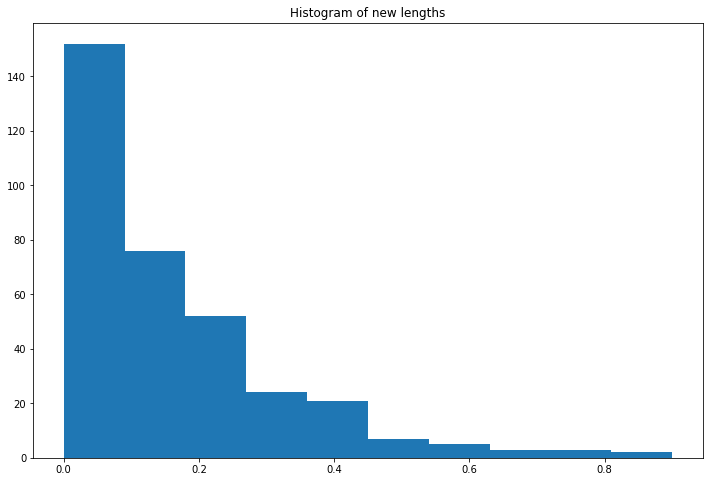

In [ ]:
with open("/content/gtts_WER.json", "r") as jsonfile:
   gtts_WER = json.load(jsonfile)

gtts_WER = np.asarray(gtts_WER)
gtts_WER = gtts_WER[:,0]
gtts_WER = list(map(float, gtts_WER))

#print("Dataset_100: ", dataset_100)
print("\ngtts WER:\n", gtts_WER)

plt.figure(figsize=(12,8))
min = np.min(gtts_WER)
max = np.max(gtts_WER)
bins2=np.arange(min, max, 0.02)
b=plt.hist(gtts_WER, range=(min,max))  # arguments are passed to np.histogram
plt.title("Histogram of new lengths")
plt.show()

In [ ]:
kws={
    'xlim': (0,1),
}


gtts WER:



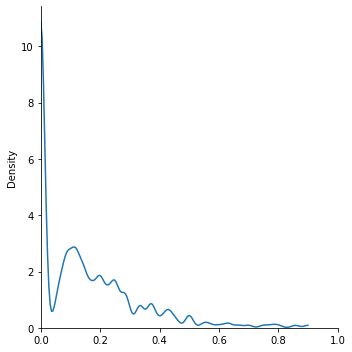

In [ ]:
with open("/content/gtts_WER.json", "r") as jsonfile:
   gtts_WER = json.load(jsonfile)

gtts_WER = np.asarray(gtts_WER)
gtts_WER = list(map(float, gtts_WER[:,0]))

print("\ngtts WER:\n")

a=sns.displot(gtts_WER, kind="kde", bw_adjust=.25, cut=0, facet_kws=kws);


ibm WER:



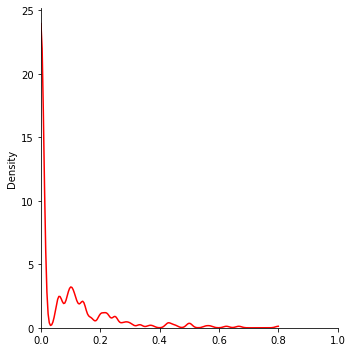

In [ ]:
with open("/content/ibm_WER.json", "r") as jsonfile:
   ibm_WER = json.load(jsonfile)

ibm_WER = np.asarray(ibm_WER)
ibm_WER = list(map(float,ibm_WER[:,0]))

print("\nibm WER:\n")

sns.displot(ibm_WER, kind="kde", bw_adjust=.25, cut=0, facet_kws=kws, color='red');


microsoft WER:



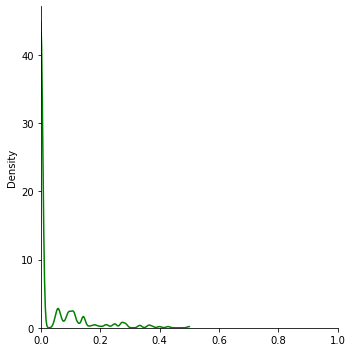

In [ ]:
with open("/content/microsoft_WER.json", "r") as jsonfile:
   microsoft_WER = json.load(jsonfile)

microsoft_WER = np.asarray(microsoft_WER)
microsoft_WER = list(map(float,microsoft_WER[:,0]))

print("\nmicrosoft WER:\n")

sns.displot(microsoft_WER, kind="kde", bw_adjust=.25, cut=0, facet_kws=kws, color='green');


Nvidia WER:



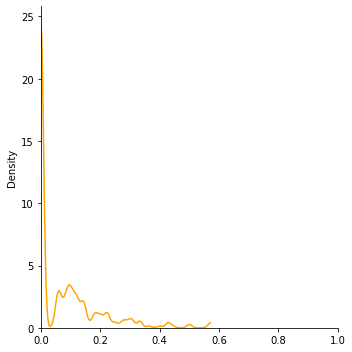

In [ ]:
with open("/content/nvidia_WER.json", "r") as jsonfile:
   nvidia_WER = json.load(jsonfile)

nvidia_WER = np.asarray(nvidia_WER)
nvidia_WER = list(map(float,nvidia_WER[:,0]))

print("\nNvidia WER:\n")

sns.displot(nvidia_WER, kind="kde", bw_adjust=.25, cut=0, facet_kws=kws, color='orange');

### boxplot

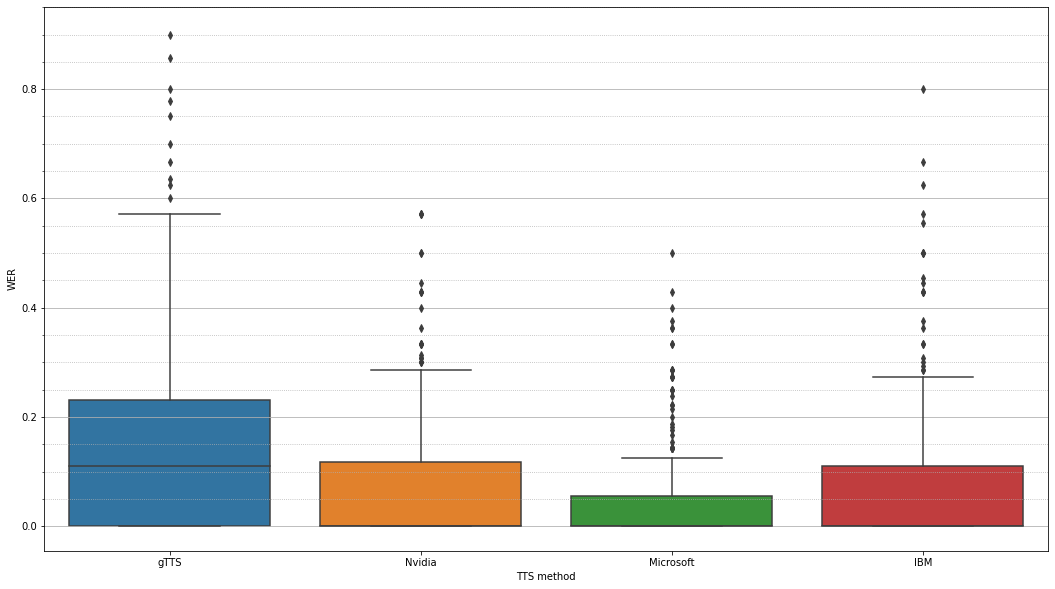

In [ ]:
discard_zeros_wer = False

d = {'TTS method': [], 'WER': []}
for w in gtts_WER:
  if not(float(w) == 0 and discard_zeros_wer):
    d['TTS method'].append('gTTS')
    d['WER'].append(float(w))
for w in nvidia_WER:
  if not(float(w) == 0 and discard_zeros_wer):
    d['TTS method'].append('Nvidia')
    d['WER'].append(float(w))
for w in microsoft_WER:
  if not(float(w) == 0 and discard_zeros_wer):
    d['TTS method'].append('Microsoft')
    d['WER'].append(float(w))
for w in ibm_WER:
  if not(float(w) == 0 and discard_zeros_wer):
    d['TTS method'].append('IBM')
    d['WER'].append(float(w))

# print("min wer value:", min(d['wer']))

df = pd.DataFrame(d)

fig, ax = plt.subplots(figsize=(18,10))
sns.boxplot(ax=ax,
                data=df,
                x='TTS method',
                y='WER')
ax.set_yticks(np.arange(0, 1, 0.05), minor=True)
plt.grid(axis='y', which='minor', linestyle='dotted')
plt.grid(axis='y', linestyle='-')
plt.show()

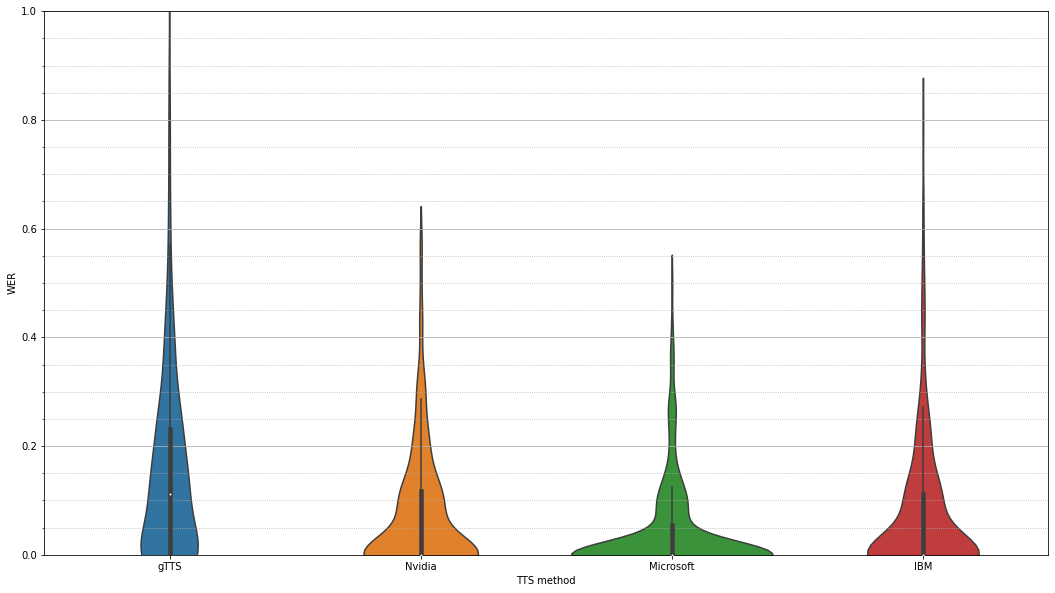

In [ ]:
fig, ax = plt.subplots(figsize=(18,10))
sns.violinplot(ax=ax,
                data=df,
                x='TTS method',
                y='WER')
ax.set_yticks(np.arange(0, 1, 0.05), minor=True)
ax.set_ylim([0, 1]) 
plt.grid(axis='y', which='minor', linestyle='dotted')
plt.grid(axis='y', linestyle='-')
plt.show()